In [1]:
import rioxarray as rxr
import contextily as ctx
import matplotlib.pyplot as plt
import os
from PIL import Image
from shapely.geometry import box
from shapely.geometry import Polygon
import shapely
import geopandas as gpd
import pickle
import leafmap

In [2]:
DATA_DIR = "data/20221220_Sudol"
CACHE = True

Plot mosaics

In [3]:
MOSAIC_DIR = f"{DATA_DIR}/mosaic"
PLOT_DIR = f"{DATA_DIR}/plot"
os.makedirs(PLOT_DIR, exist_ok=True)
CACHE_DIR = f"{DATA_DIR}/cache"
os.makedirs(CACHE_DIR, exist_ok=True)

In [4]:
uncal_last = rxr.open_rasterio(f"{MOSAIC_DIR}/mosaic_uncal_LAST.tif", masked=True)
uncal_mean = rxr.open_rasterio(f"{MOSAIC_DIR}/mosaic_uncal_MEAN.tif", masked=True)
cal_last = rxr.open_rasterio(f"{MOSAIC_DIR}/mosaic_cal_LAST.tif", masked=True)
cal_mean = rxr.open_rasterio(f"{MOSAIC_DIR}/mosaic_cal_MEAN.tif", masked=True)

In [5]:
m = leafmap.Map()
m.add_raster(f"{MOSAIC_DIR}/mosaic_uncal_LAST.tif", colormap="terrain", layer_name="cal_last")
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

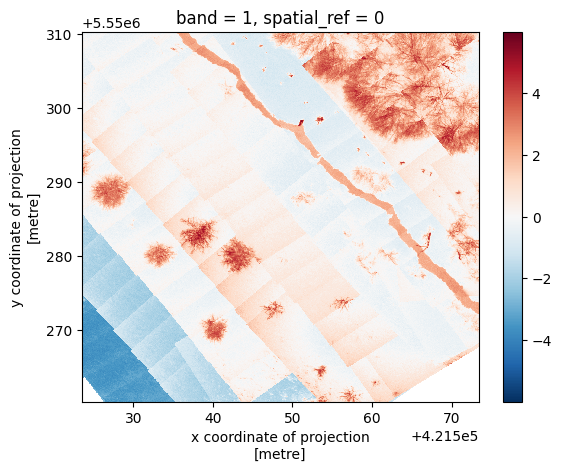

In [6]:
gdf = gpd.GeoDataFrame(geometry=[Polygon(item['geometry']['coordinates'][0]) for item in m.draw_features], crs="EPSG:4326").to_crs(cal_mean.rio.crs)
#set geometry to envelope
gdf['geometry'] = gdf.geometry.envelope
gdf['size'] = gdf.area**0.5
gdf['geometry'] = gdf.apply(lambda row: shapely.geometry.box(row['geometry'].bounds[0], row['geometry'].bounds[1], row['geometry'].bounds[0]+row['size'], row['geometry'].bounds[1]+row['size']), axis=1)
square = gdf.geometry
uncal_last.rio.clip(square).plot()


In [7]:
# #load pickle square.pkl
# with open(f"{CACHE_DIR}/vis_square.pkl", 'rb') as f:
#     square = pickle.load(f)

In [8]:
uncal_last = uncal_last.rio.clip(square)
uncal_mean = uncal_mean.rio.clip(square)
cal_last = cal_last.rio.clip(square)
cal_mean = cal_mean.rio.clip(square)

In [9]:

#get min and max values for all rasters using percentile
min_val = min(uncal_last.quantile(0.02), uncal_mean.quantile(0.02), cal_last.quantile(0.02), cal_mean.quantile(0.02))
max_val = max(uncal_last.quantile(0.98), uncal_mean.quantile(0.98), cal_last.quantile(0.98), cal_mean.quantile(0.98))

In [10]:
for raster, title in zip([uncal_last, uncal_mean, cal_last, cal_mean], ["uncal_last", "uncal_mean", "cal_last", "cal_mean"]):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axes.set_aspect('equal')
    #plot but maintain aspect ratio
    #raster_plot = raster.plot(ax=ax, vmin=min_val, vmax=max_val, cmap="viridis", aspect="equal")
    #plot with viridis colormap
    raster_plot = raster.plot(ax=ax, vmin=min_val, vmax=max_val, cmap="gray_r")
    #hide colorbar
    ax.collections[0].colorbar.remove()
    #hide axis
    ax.axis('off')
    #remove title
    ax.set_title("")
    #make margins smaller
    #plt.margins(0,0)
    #margins still are big
    fig.tight_layout(pad=0.5)
    #ctx.add_basemap(ax, crs=raster.rio.crs, source=ctx.providers.Esri.WorldImagery)
    #ax.set_title(title)
    #save plot
    fig.savefig(f"{PLOT_DIR}/{title}.png")
    #destroy plot
    plt.close(fig)


In [13]:
#save colorbar in separate file
fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 30})
cbar = plt.colorbar(raster_plot, ax=ax, orientation="vertical")
#place labe below colorbar
cbar.ax.set_title("°C")
#place °C above colorbar

ax.remove()
#make letters bigger

#fig.tight_layout(pad=0.5)
#crop figure
fig.savefig(f"{PLOT_DIR}/colorbar.png", bbox_inches='tight', pad_inches=0)
#plt.savefig(f"{PLOT_DIR}/colorbar.png")
plt.close(fig)

In [21]:
with open(f"{CACHE_DIR}/vis_square.pkl", "wb") as f:
    pickle.dump(square, f)